In [1]:
# Menginstal library yang diperlukan
!pip install tensorflow keras matplotlib scikit-learn opencv-python-headless pillow gradio

# Mengimpor library dasar
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from PIL import Image

# Mengautentikasi Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Definisikan path dataset di Google Drive Anda
dataset_path = '/content/drive/MyDrive/Semester 8/Computer Vision/FaridMuhammadHidayat_ProjectComputerVision/Dataset/data' # Sesuaikan dengan lokasi dataset Anda

# Verifikasi struktur dataset (optional)
print("Isi folder dataset:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files[:3]: # Hanya tampilkan beberapa file per folder
        print(f'{subindent}{f}')
    if len(files) > 3:
        print(f'{subindent}...')

# Pastikan folder train dan validation terpisah jika belum ada
# Jika dataset Anda sudah terstruktur dengan folder train/val, lewati bagian ini
# Jika tidak, kita akan membagi secara manual

# Membuat direktori untuk data pelatihan dan validasi
base_dir = '/content/hair_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Definisikan kelas-kelas tipe rambut
classes = ['curly', 'dreadlocks', 'kinky', 'Straight', 'Wavy'] # Corrected 'straight' to 'Straight' and 'wavy' to 'Wavy'

# Proporsi pembagian data (misal 80% train, 20% validation)
split_ratio = 0.8

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    images = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    train_split = int(len(images) * split_ratio)
    train_images = images[:train_split]
    val_images = images[train_split:]

    # Buat direktori kelas di dalam train dan validation
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, cls), exist_ok=True)

    # Pindahkan gambar ke direktori yang sesuai
    print(f"Memproses {cls}...")
    for img_path in train_images:
        shutil.copy(img_path, os.path.join(train_dir, cls, os.path.basename(img_path)))
    for img_path in val_images:
        shutil.copy(img_path, os.path.join(validation_dir, cls, os.path.basename(img_path)))

print("Dataset berhasil dibagi dan disiapkan.")

# Parameter augmentasi dan generator data
image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Menampilkan mapping kelas
print("\nClass Indices:", train_generator.class_indices)
class_labels = {v: k for k, v in train_generator.class_indices.items()}
print("Class Labels:", class_labels)

Isi folder dataset:
data/
    curly/
        ACC-haircream-3_1500x.jpg
        9b3608e01d78fbabc9fb0719323d507f4.jpg
        5d6da4c89b006262ecfab1f48c5e197f (3).jpg
        ...
    kinky/
        1D4BEE15-858B-4699-B070-55B9B1D6000B2x.jpg
        59c5de9754e7930b06ab415297b65cbc10.jpg
        057656ef97f71b87e933f8608e3e1f7b.jpg
        ...
    dreadlocks/
        567222c5f2251f660d283d803845d1fc.jpg
        5-loc-style-for-women-CUXCgKxK4jW.jpg
        19-long-hair-locs-with-square-parting-CEDQMZjJnZV.jpg
        ...
    Straight/
        1_Emily-Atack.jpg
        198cd7c33975b5a4fcffb99415cd1b6b.jpg
        286b03b2ad1c09bf52cbcc99a4dabba4.jpg
        ...
    Wavy/
        34be707dfe1fb0e431b21764757a4e88.jpg
        Classy-Hairstyle-for-Thick-Wavy-Hair.jpg
        40017483c7a93d157d92bb8821560d575.jpg
        ...
Memproses curly...
Memproses dreadlocks...
Memproses kinky...
Memproses Straight...
Memproses Wavy...
Dataset berhasil dibagi dan disiapkan.
Found 1776 images belonging to

In [4]:
# Membangun model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5), # Regularization untuk mencegah overfitting
    Dense(512, activation='relu'),
    Dense(len(classes), activation='softmax') # Output layer dengan jumlah kelas
])

# Mengkompilasi model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,173 (13.18 MB)

 Trainable params: 3,455,173 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2637 - loss: 1.5746

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.2638 - loss: 1.5743 - val_accuracy: 0.3142 - val_loss: 1.4747
Epoch 2/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.4062 - loss: 1.4929

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 338ms/step - accuracy: 0.4062 - loss: 1.4929 - val_accuracy: 0.2795 - val_loss: 1.4789
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.3045 - loss: 1.5214 - val_accuracy: 0.4375 - val_loss: 1.3736
Epoch 4/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.2812 - loss: 1.5568

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - accuracy: 0.2812 - loss: 1.5568 - val_accuracy: 0.4635 - val_loss: 1.3711
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.3731 - loss: 1.4532 - val_accuracy: 0.4809 - val_loss: 1.2914
Epoch 6/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.4688 - loss: 1.5261

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.4688 - loss: 1.5261 - val_accuracy: 0.4722 - val_loss: 1.2945
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.3833 - loss: 1.4422 - val_accuracy: 0.4149 - val_loss: 1.4197
Epoch 8/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.5000 - loss: 1.3867

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.5000 - loss: 1.3867 - val_accuracy: 0.4115 - val_loss: 1.4293
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4052 - loss: 1.4171 - val_accuracy: 0.4826 - val_loss: 1.3023
Epoch 10/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.4062 - loss: 1.2308

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.4062 - loss: 1.2308 - val_accuracy: 0.4670 - val_loss: 1.3355
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.4249 - loss: 1.3608 - val_accuracy: 0.3542 - val_loss: 1.5936
Epoch 12/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.4062 - loss: 1.2750

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.4062 - loss: 1.2750 - val_accuracy: 0.3733 - val_loss: 1.5578
Epoch 13/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.4415 - loss: 1.3599 - val_accuracy: 0.4722 - val_loss: 1.3157
Epoch 14/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.3125 - loss: 1.3189

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.3125 - loss: 1.3189 - val_accuracy: 0.4566 - val_loss: 1.3344
Epoch 15/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.4624 - loss: 1.2971 - val_accuracy: 0.4792 - val_loss: 1.2852
Epoch 16/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.4062 - loss: 1.3165

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.4062 - loss: 1.3165 - val_accuracy: 0.4948 - val_loss: 1.2858
Epoch 17/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.4801 - loss: 1.2835 - val_accuracy: 0.4948 - val_loss: 1.3081
Epoch 18/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.4688 - loss: 1.2021

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 361ms/step - accuracy: 0.4688 - loss: 1.2021 - val_accuracy: 0.4913 - val_loss: 1.3350
Epoch 19/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4703 - loss: 1.2576 - val_accuracy: 0.5312 - val_loss: 1.2195
Epoch 20/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.5312 - loss: 1.2203

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.5312 - loss: 1.2203 - val_accuracy: 0.5139 - val_loss: 1.2339
Epoch 21/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5108 - loss: 1.1876 - val_accuracy: 0.5469 - val_loss: 1.1750
Epoch 22/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.5938 - loss: 1.3412

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 0.5938 - loss: 1.3412 - val_accuracy: 0.5451 - val_loss: 1.1418
Epoch 23/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4938 - loss: 1.2177 - val_accuracy: 0.5729 - val_loss: 1.1813
Epoch 24/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 35s 648ms/step - accuracy: 0.4375 - loss: 1.1971

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.4375 - loss: 1.1971 - val_accuracy: 0.5625 - val_loss: 1.1964
Epoch 25/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5392 - loss: 1.1708 - val_accuracy: 0.5035 - val_loss: 1.2427
Epoch 26/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.5625 - loss: 1.1368

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.5625 - loss: 1.1368 - val_accuracy: 0.4948 - val_loss: 1.2625
Epoch 27/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.5184 - loss: 1.1909 - val_accuracy: 0.5677 - val_loss: 1.1946
Epoch 28/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.5938 - loss: 0.9666

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.5938 - loss: 0.9666 - val_accuracy: 0.5990 - val_loss: 1.1229
Epoch 29/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.5292 - loss: 1.1596 - val_accuracy: 0.5833 - val_loss: 1.0891
Epoch 30/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.5625 - loss: 0.9842

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.5625 - loss: 0.9842 - val_accuracy: 0.5729 - val_loss: 1.1114
Epoch 31/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.5112 - loss: 1.1892 - val_accuracy: 0.6076 - val_loss: 1.1080
Epoch 32/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.5312 - loss: 1.0851

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.5312 - loss: 1.0851 - val_accuracy: 0.5972 - val_loss: 1.1018
Epoch 33/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.5621 - loss: 1.0897 - val_accuracy: 0.5747 - val_loss: 1.1377
Epoch 34/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.5938 - loss: 1.0562

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.5938 - loss: 1.0562 - val_accuracy: 0.5712 - val_loss: 1.1595
Epoch 35/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.5664 - loss: 1.0829 - val_accuracy: 0.5781 - val_loss: 1.2011
Epoch 36/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.5312 - loss: 1.0869

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step - accuracy: 0.5312 - loss: 1.0869 - val_accuracy: 0.5938 - val_loss: 1.1660
Epoch 37/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.5636 - loss: 1.1042 - val_accuracy: 0.4861 - val_loss: 1.3597
Epoch 38/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.4688 - loss: 1.3620

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.4688 - loss: 1.3620 - val_accuracy: 0.4792 - val_loss: 1.3845
Epoch 39/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.5471 - loss: 1.1148 - val_accuracy: 0.6007 - val_loss: 1.0928
Epoch 40/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.6875 - loss: 1.0079

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.6875 - loss: 1.0079 - val_accuracy: 0.6094 - val_loss: 1.0826
Epoch 41/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5287 - loss: 1.1442 - val_accuracy: 0.6024 - val_loss: 1.0767
Epoch 42/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.5938 - loss: 0.9524

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.5938 - loss: 0.9524 - val_accuracy: 0.5990 - val_loss: 1.1164
Epoch 43/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.5808 - loss: 1.0724 - val_accuracy: 0.6007 - val_loss: 1.0175
Epoch 44/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.5000 - loss: 1.0754

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.5000 - loss: 1.0754 - val_accuracy: 0.6337 - val_loss: 0.9849
Epoch 45/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.5802 - loss: 1.0800 - val_accuracy: 0.5781 - val_loss: 1.1698
Epoch 46/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.5312 - loss: 1.1156

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.5312 - loss: 1.1156 - val_accuracy: 0.6059 - val_loss: 1.0912
Epoch 47/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.5586 - loss: 1.0805 - val_accuracy: 0.6094 - val_loss: 1.1435
Epoch 48/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.5000 - loss: 1.3338

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.5000 - loss: 1.3338 - val_accuracy: 0.6024 - val_loss: 1.1460
Epoch 49/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5551 - loss: 1.0732 - val_accuracy: 0.6354 - val_loss: 1.0002
Epoch 50/50
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.4375 - loss: 1.2152

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.4375 - loss: 1.2152 - val_accuracy: 0.6302 - val_loss: 0.9944


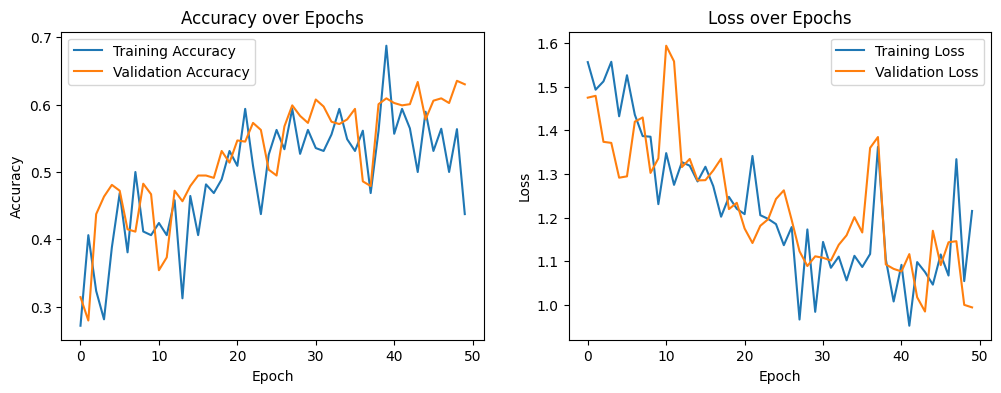

In [5]:
# Melatih model
epochs = 50 # Anda bisa menyesuaikan jumlah epoch

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Menyimpan model
model_save_path = '/content/drive/MyDrive/hair_type_classifier_model.h5'
model.save(model_save_path)
print(f"Model berhasil disimpan di: {model_save_path}")

Model berhasil disimpan di: /content/drive/MyDrive/hair_type_classifier_model.h5


In [7]:
# Memuat model yang telah disimpan
from tensorflow.keras.models import load_model

try:
    loaded_model = load_model(model_save_path)
    print("Model berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat model: {e}. Pastikan path model benar dan model sudah disimpan.")

# Mapping rekomendasi perawatan untuk setiap tipe rambut
hair_care_recommendations = {
    'curly': "Rambut keriting membutuhkan hidrasi ekstra. Gunakan produk bebas sulfat, kondisioner yang kaya, dan rutin menggunakan masker rambut. Hindari menyisir rambut saat kering dan gunakan teknik 'plop' untuk mengeringkan.",
    'dreadlocks': "Dreadlocks membutuhkan pembersihan rutin untuk menghindari penumpukan produk dan menjaga kebersatan. Gunakan sampo khusus dreadlocks dan pastikan untuk mengeringkan sepenuhnya untuk mencegah jamur. Minyak alami seperti tea tree oil dapat membantu menjaga kesehatan kulit kepala.",
    'kinky': "Rambut kinky sangat kering dan rapuh. Fokus pada pelembapan intensif dengan leave-in conditioner, minyak alami (kelapa, shea butter), dan teknik 'LOC' (Liquid, Oil, Cream). Lindungi rambut di malam hari dengan satin bonnet atau sarung bantal sutra.",
    'straight': "Rambut lurus cenderung berminyak lebih cepat. Gunakan sampo yang membersihkan tanpa membuat kering dan kondisioner ringan. Hindari produk berlebihan yang bisa membuat rambut lepek. Keramas secara teratur dan sisir rambut dengan lembut.",
    'wavy': "Rambut bergelombang berada di antara lurus dan keriting. Gunakan produk yang ringan untuk menambah volume dan definisi tanpa membuat rambut berat. Scrunch rambut saat basah untuk membentuk gelombang dan biarkan kering secara alami atau gunakan diffuser."
}

def predict_hair_type(image_path_or_array):
    """
    Melakukan prediksi tipe rambut dari gambar.
    Menerima path gambar atau numpy array gambar.
    """
    try:
        if isinstance(image_path_or_array, str):
            img = Image.open(image_path_or_array).convert('RGB')
        else: # Asumsi ini adalah numpy array dari Gradio
            img = Image.fromarray(image_path_or_array).convert('RGB')

        img = img.resize(image_size)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0) # Tambahkan dimensi batch

        predictions = loaded_model.predict(img_array)[0]

        # Mengurutkan prediksi dari persentase tertinggi
        sorted_predictions_indices = np.argsort(predictions)[::-1]

        results = {}
        for i in sorted_predictions_indices:
            label = class_labels[i]
            percentage = predictions[i] * 100
            results[label] = percentage

        # Tipe rambut dengan persentase tertinggi
        predicted_class_index = np.argmax(predictions)
        predicted_label = class_labels[predicted_class_index]

        recommendation = hair_care_recommendations.get(predicted_label, "Tidak ada rekomendasi spesifik untuk tipe rambut ini.")

        output_string = "### Hasil Analisis Tipe Rambut:\n\n"
        for label, percentage in results.items():
            output_string += f"- **{label.capitalize()}**: {percentage:.2f}%\n"

        output_string += f"\n---"
        output_string += f"\n### Tipe Rambut Teridentifikasi: **{predicted_label.capitalize()}**"
        output_string += f"\n\n### Rekomendasi Perawatan:\n"
        output_string += recommendation

        return output_string

    except Exception as e:
        return f"Terjadi kesalahan: {e}"

Model berhasil dimuat.


In [8]:
import gradio as gr

# Membuat antarmuka Gradio
if 'loaded_model' in locals():
    interface = gr.Interface(
        fn=predict_hair_type,
        inputs=gr.Image(type="numpy", label="Unggah Gambar Model Rambut"),
        outputs=gr.Markdown(label="Hasil Prediksi dan Rekomendasi"),
        title="Klasifikasi Tipe Rambut dan Rekomendasi Perawatan",
        description="Unggah gambar model rambut untuk mendapatkan prediksi tipe rambut (Curly, Dreadlocks, Kinky, Straight, Wavy) dan rekomendasi perawatan."
    )

    # Menjalankan antarmuka Gradio
    interface.launch(share=True) # share=True akan menghasilkan link publik sementara
else:
    print("Model belum dimuat. Tidak dapat meluncurkan Gradio interface.")

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://908139c11b9800ede3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [9]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [10]:
import sys
import platform
import pkg_resources

print(f"Python Version: {sys.version}")
print(f"Operating System: {platform.platform()}")

print("\n--- Library Versions ---")

libraries_to_check = [
    "tensorflow",
    "keras",
    "gradio",
    "Pillow", # Pillow is imported as PIL, but its package name is Pillow
    "numpy"
]

for lib in libraries_to_check:
    try:
        # For direct package names like tensorflow, numpy, gradio
        version = pkg_resources.get_distribution(lib).version
        print(f"{lib.capitalize()} Version: {version}")
    except pkg_resources.DistributionNotFound:
        # Handle cases where the package might be imported under a different name
        # or not installed
        if lib == "Pillow":
            try:
                import PIL
                print(f"Pillow (PIL) Version: {PIL.__version__}")
            except ImportError:
                print(f"{lib.capitalize()} not found.")
        else:
            print(f"{lib.capitalize()} not found.")
    except Exception as e:
        print(f"Error checking {lib.capitalize()} version: {e}")

# Optional: You can also try to import and print __version__ for some libraries directly
# import tensorflow as tf
# print(f"TensorFlow __version__: {tf.__version__}")
# import gradio as gr
# print(f"Gradio __version__: {gr.__version__}")
# import numpy as np
# print(f"NumPy __version__: {np.__version__}")
# import PIL
# print(f"Pillow __version__: {PIL.__version__}")

Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Operating System: Linux-6.1.123+-x86_64-with-glibc2.35

--- Library Versions ---
Tensorflow Version: 2.18.0
Keras Version: 3.8.0
Gradio Version: 5.31.0
Pillow Version: 11.2.1
Numpy Version: 2.0.2


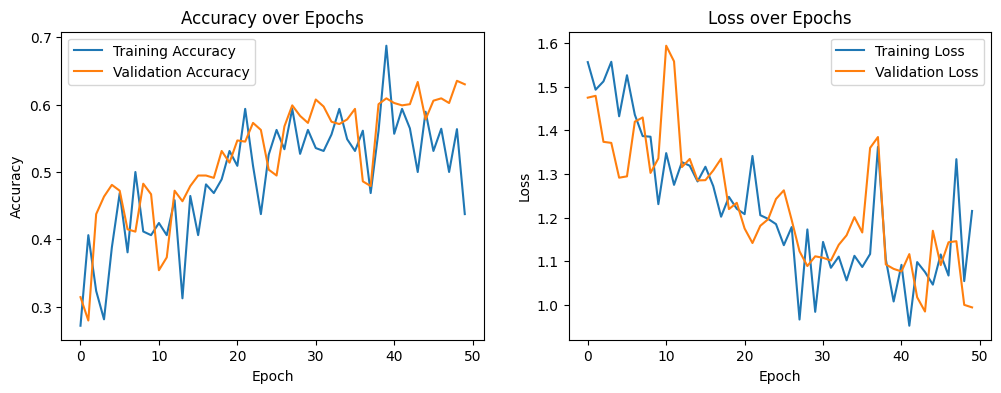

In [11]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()